# Environmetal sound classification


<a href="https://colab.research.google.com/github/GianmarcoLattaruolo/Vision_Project/blob/main/Vision_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis




Run this cell again if you modify some scripts.

In [1]:
import sys  
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa
from scipy.io import wavfile
import seaborn as sb
sb.set(style="white", palette="muted")
import pandas as pd
import IPython.display as ipd
import time
from scipy import signal


#libraries
main_dir = os.getcwd()
module_path = main_dir
if module_path not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(module_path)

import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis

Run this cell once to download the dataset.


In [2]:
in_colab = 'google.colab' in sys.modules
if in_colab:
    print('Downloading the ESC-50 dataset')
    download_dataset('ESC-50')

## Preliminary Exploration of the dataset

In this cell we can listen to one random audio in our dataset (different every time we run the cell). 
Moreover we visualize a portion of the audio.


The sample rate is44100
The data shape is (220500,)
Audio category: crackling_fire


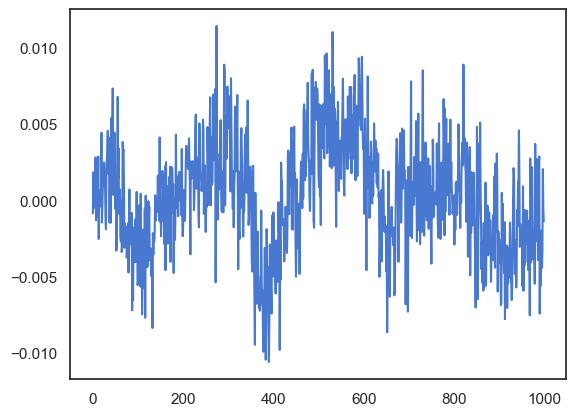

In [3]:
importlib.reload(importlib.import_module('Preprocessing.exploration_plots'))
from Preprocessing.exploration_plots import one_random_audio
audio, samplerate = one_random_audio(main_dir)

With this cell we load the pandas dataframe with the information about the datsets.

In [4]:
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 , df_ESC_US = load_metadata(main_dir, ESC_US = True, statistics=True)
# default values are:
# heads = True, statistics = False, audio_listen = False, ESC50=True, ESC10=True, ESC_US=False

filename  fold  target        category  esc10  src_file take  \
0   1-100032-A-0.wav     1       0             dog   True    100032    A   
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A   
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A   
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B   
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A   

                                           full_path  
0  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
1  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
2  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
3  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
4  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...

Classes in the full dataset  are perfectly balanced
 Counter({'dog': 40, 'chirping_birds': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'pouring_water': 40, 'train': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'car_horn': 40, 'crackling_fire': 40, 'helicopter': 40, 'drinking_sipping': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass_breaking': 40, 'snoring': 40, 'toilet_flush': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40})


filename  fold  target        category  src_file take  \
0    1-100032-A-0.wav     1       0             dog    100032    A   
14   1-110389-A-0.wav     1       0             dog    110389    A   
24  1-116765-A-41.wav     1      41        chainsaw    116765    A   
54   1-17150-A-12.wav     1      12  crackling_fire     17150    A   
55  1-172649-A-40.wav     1      40      helicopter    172649    A   

                                            full_path  
0   /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
14  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
24  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
54  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...  
55  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...

Classes in ESC10 
 ['clock_tick', 'sea_waves', 'rooster', 'chainsaw', 'dog', 'helicopter', 'rain', 'crackling_fire', 'sneezing', 'crying_baby']

librosa takes : 2.7142789363861084
the lengths are {220500}
the sample rates are {44100}
Loading the 1/2 folder of unlabeled data 
Loading the 2/2 folder of unlabeled data 
We have 20000 unlabeled audios.


filename                                          full_path
0    016514-31948-40-45.ogg  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...
1      019507-35054-0-5.ogg  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...
2  016972-32311-300-305.ogg  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...
3    016774-32197-50-55.ogg  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...
4  014522-29650-260-265.ogg  /Users/leonardo/Desktop/HDA/Human_Data_Analyti...

We can say that, as we expected, this type of analysis on the entire audio clip is meaningless. We'll need to fragment the audio clips.
But first let's produce some summary statistics about our dataset.

## Spectrogram Analysis

Now we dig in the analysis exploiting the natural structure of sound in nature. 
In particular we'll need the [Short-Time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform).

Frame length is 882
Overlap length is 441
The length of the windowed signal after padding with zeros (frames) is 882. 


Scipy STFT shape (442, 501)
Scipy; length of frequencies vector (442,)
Scipy; length of time vector (501,)


librosa STFT shape (442, 501)
Librosa frames_to_time has shape (501,), (the time vector for STFT)
Is it equal to the time vector of Scipy? True
Librosa fft_frequencies has shape (442,) (compute the frequencies given the sample_rate and the windowed length)
Is it equal to Scipy frequencies? True


The STFT converted in decibell domain ha shape (442, 501)
Librosa Mel spectrogram of the audio has shape (128, 501) 
Librosa MFCC features has shape (40, 501)




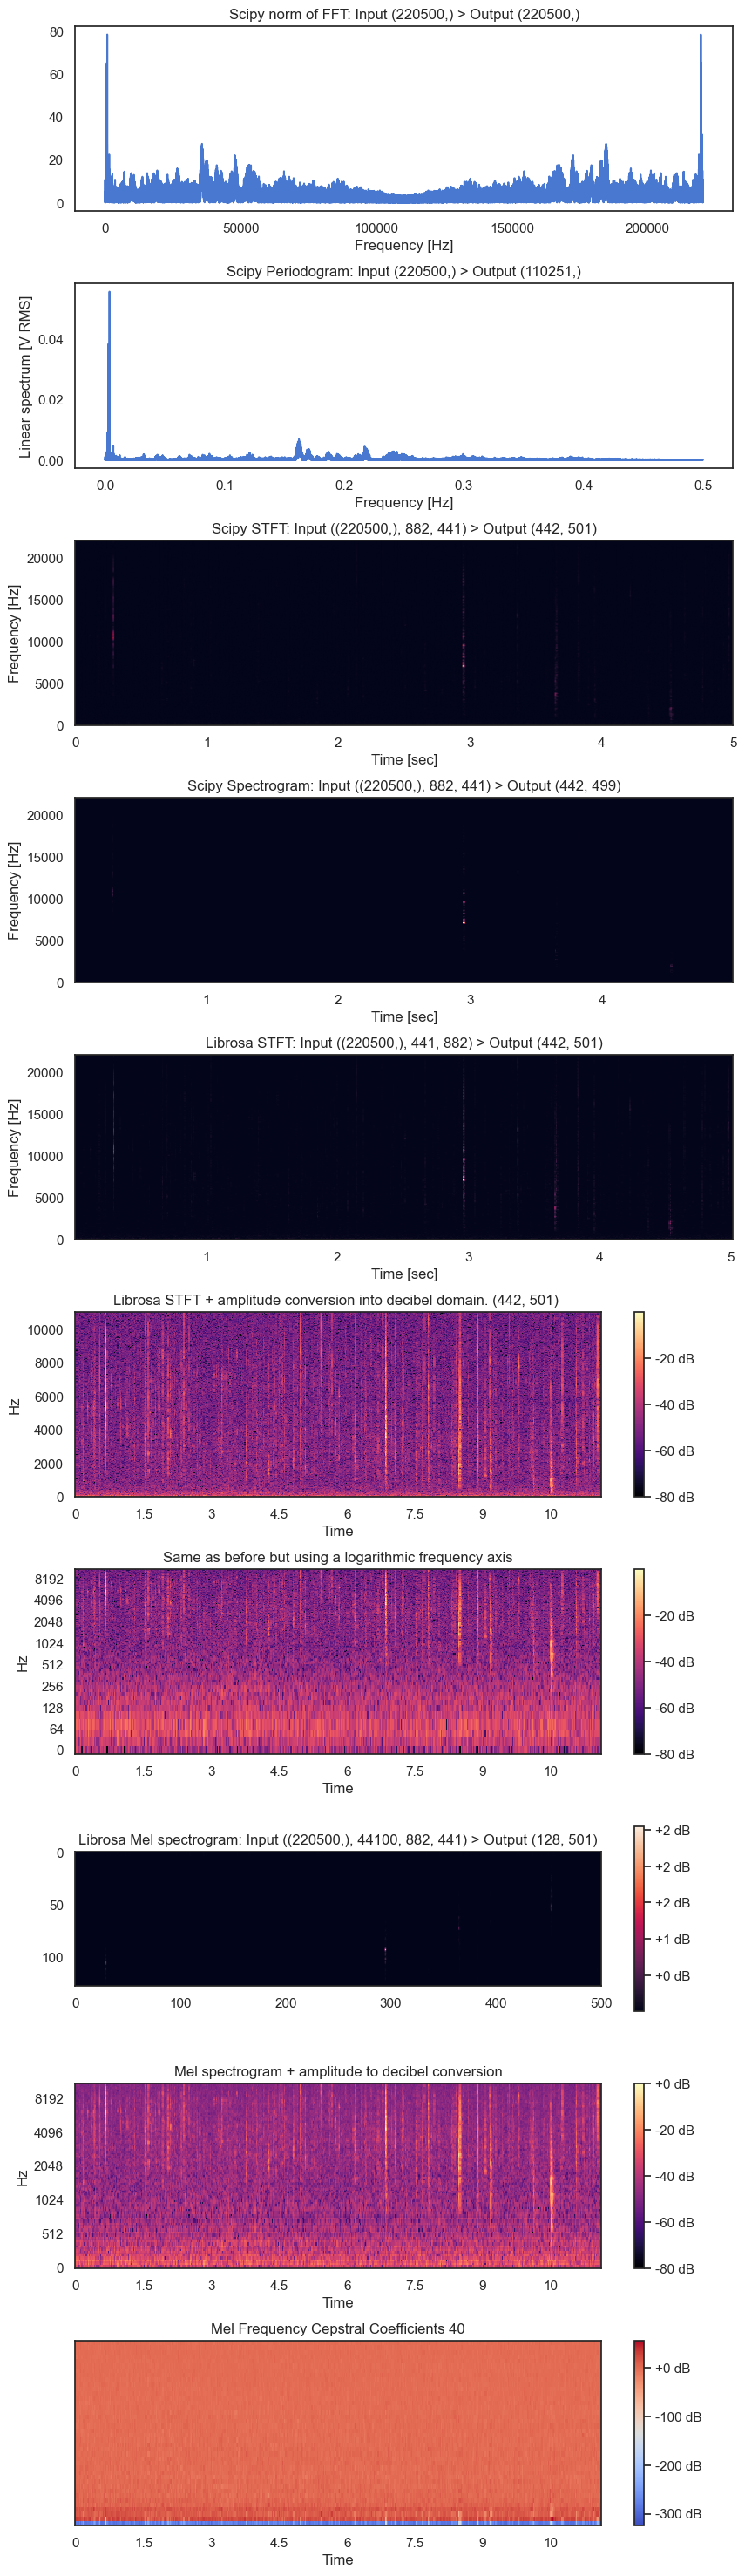

In [5]:
importlib.reload(importlib.import_module('Preprocessing.exploration_plots'))
from Preprocessing.exploration_plots import Spectral_Analysis
mfcc_audio = Spectral_Analysis(audio,
                                                   sample_rate = 44100,
                                                   segment = 20,
                                                   n_fft = None, #padd the frames with zeros before DFT
                                                   overlapping = 10,
                                                   cepstral_num = 40, #number of mel frequencies cepstral coefficients
                                                   N_filters = 50, #number of mel filters in frequency domain
                                                   plot = True, #default is false
                                                   verbose = True, #default is false
                                                   STFT_decibel = False,
                                                   Mel_spectrogram_decibel = False,
                                                   MFCC = True)

Now we plot 5 STFTs converted into decibel domain and in logarithm scale (plot number 6 in previous cell) for each category of audio in our dataset.

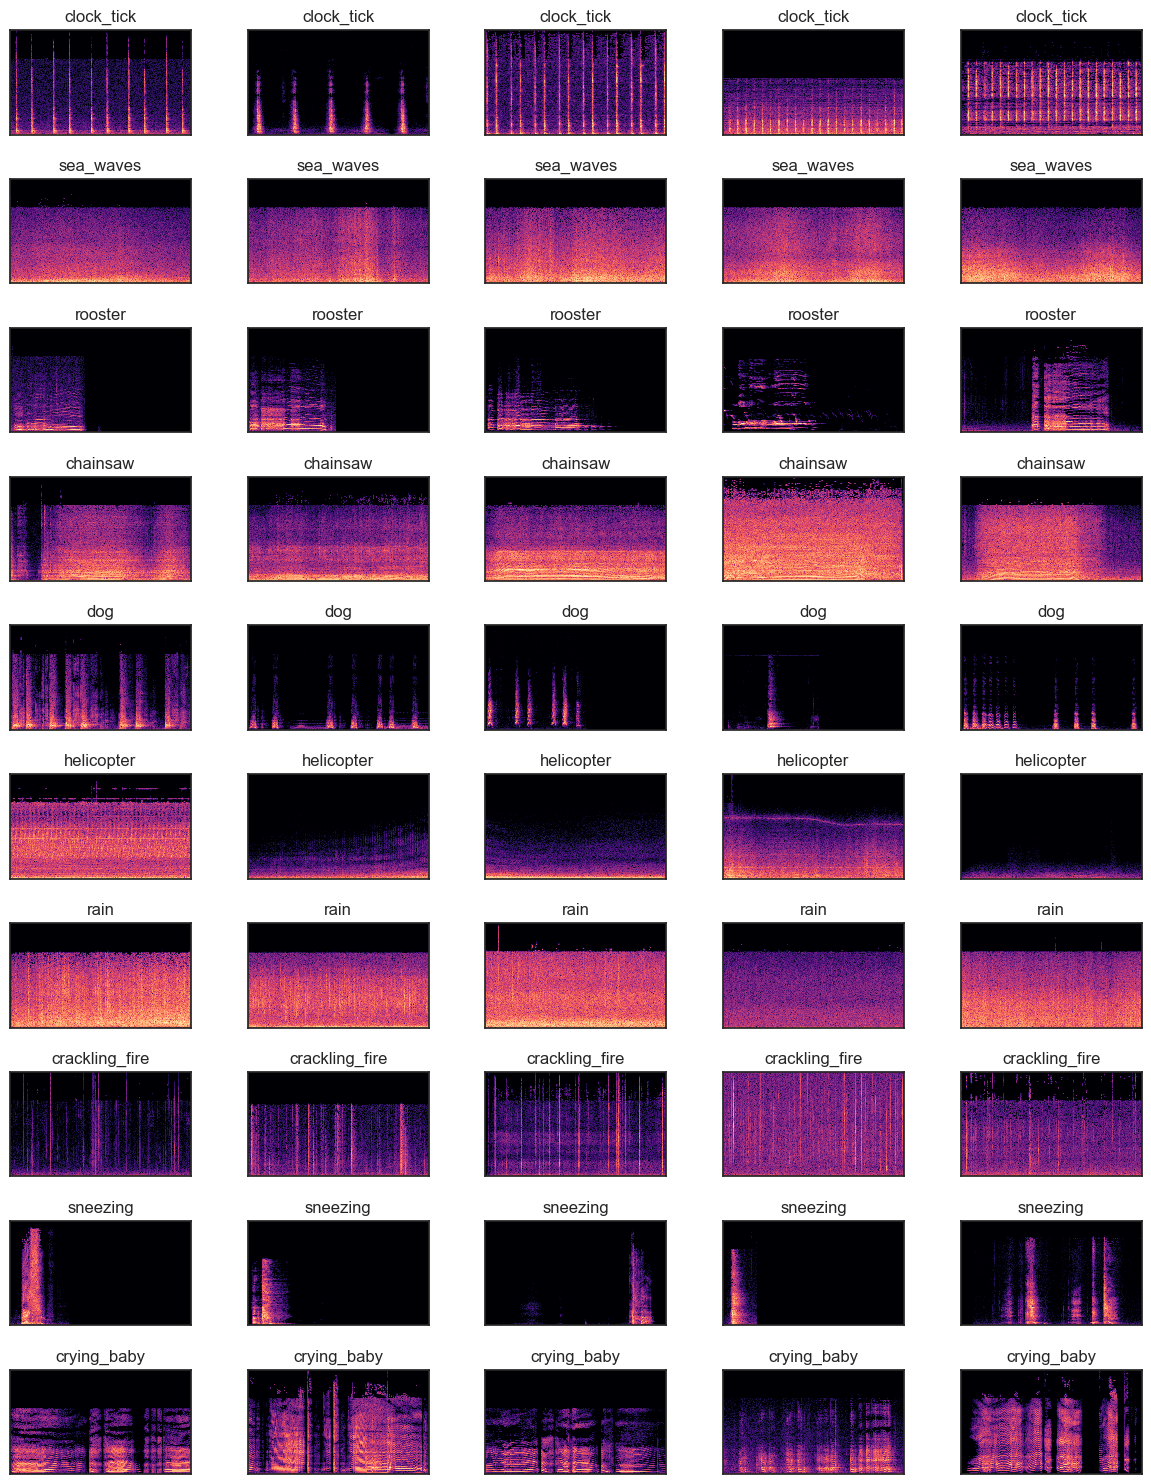

In [6]:
importlib.reload(importlib.import_module('Preprocessing.exploration_plots'))
from Preprocessing.exploration_plots import plot_clip_overview
plot_clip_overview(df_ESC10) #clearly you can pass only df_ESC10 or df_ESC50

/Users/leonardo/opt/anaconda3/envs/DSEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: pcen was called on complex input so phase information will be discarded. To suppress this warning, call pcen(np.abs(D)) instead.
  


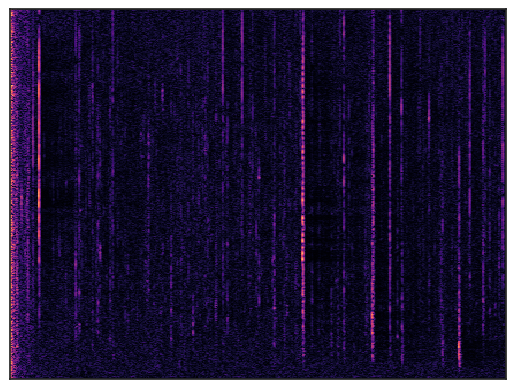

In [7]:
S = librosa.stft(audio)
S_db = librosa.pcen(S*(2**31), max_size=5)
librosa.display.specshow(S_db)



/Users/leonardo/opt/anaconda3/envs/DSEnv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  """Entry point for launching an IPython kernel.


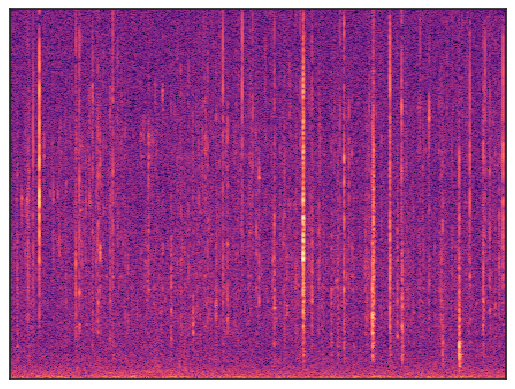

In [8]:
S_db = librosa.amplitude_to_db(S)
librosa.display.specshow(S_db)

Now let's create a dataset for our models.

## Dataset creation

The first approach we can try is to simply build pandas dataframes with our raw audio. 
We can see that this approach is unfeasible in the case of the unlabeled dataset.

### Pandas dataset

In [9]:
build_ESC_US_df = False
save_csv = False

audio_paths = df_ESC10.full_path

start_time = time.time()
audio_data = []
for audio_path in audio_paths:
    audio, _ = librosa.load(audio_path, sr=44100)  # Set sr=None to load the audio file with its original sampling rate
    audio_data.append(audio)
pd_df_ESC10 = pd.DataFrame({'audio': audio_data, 'target': df_ESC10['target']})
print(f'To build the ESC10 dataframe we need {time.time()-start_time} seconds.')
print(f'The pandas data frame for ESC10 occupies {sys.getsizeof(pd_df_ESC10)/1000} kbytes')

audio_paths = df_ESC50.full_path
start_time = time.time()
audio_data = []
for audio_path in audio_paths:
    audio, _ = librosa.load(audio_path, sr=44100)  # Set sr=None to load the audio file with its original sampling rate
    audio_data.append(audio)
pd_df_ESC50 = pd.DataFrame({'audio': audio_data, 'target': df_ESC50['target']})
print(f'To build the ESC50 dataframe we need {time.time()-start_time} seconds.')
print(f'The pandas data frame for ESC50 occupies {sys.getsizeof(pd_df_ESC50)/1000} kbytes')

if build_ESC_US_df:
        
    audio_paths = df_ESC_US.full_path
    start_time = time.time()
    audio_data = np.zeros((20000,220500), dtype=np.float16) # we must decrease a lot the precision to fit in our RAM.
    for i,audio_path in enumerate(audio_paths):
        if i%1000==0:
            print(f'Loading the {i}-th unlabeled audio')
        audio, _ = librosa.load(audio_path, sr=44100)  # Set sr=None to load the audio file with its original sampling rate
        audio_data[i,:] = audio
    pd_df_ESC_US = pd.DataFrame((audio_data),columns=[i for i in range(220500)])
    print(f'To build the ESC-US dataframe we need {time.time()-start_time} seconds.')
    print(f'The pandas data frame for ESC-US occupies {sys.getsizeof(pd_df_ESC_US)/1000} kbytes')
    
if save_csv:

    pd_df_ESC10.to_csv(path_or_buf=os.path.join(main_dir,'data','meta','dataset_ESC10.csv'), index=False)
    pd_df_ESC50.to_csv(path_or_buf=os.path.join(main_dir,'data','meta','dataset_ESC50.csv'), index=False)
    #pd_df_ESC_US.to_csv(path_or_buf=os.path.join(main_dir,'data','meta','dataset_ESC_US.csv'), index=False) #we cannot save this, it's too big!



To build the ESC10 dataframe we need 0.3603968620300293 seconds.
The pandas data frame for ESC10 occupies 51.232 kbytes
To build the ESC50 dataframe we need 3.0167617797851562 seconds.
The pandas data frame for ESC50 occupies 240.16 kbytes


## Tensorflow dataset funziona ma crea oggetti ti tipo diverso

We must follow the tensoflow dataset API strategy to handle the RAM limitation.

In [27]:
import tensorflow as tf
import numpy as np
#tf.compat.v1.enable_eager_execution() # to check immediately
#print(tf.executing_eagerly())
#tf.compat.v1.disable_eager_execution()


def create_tf_dataset(metadata):
    #metadata is a pandas dataframe with the metadata of the audios 
    audio_paths = metadata['full_path']

    if 'target' in metadata.columns:
        targets = metadata['target'] 

        def load_audio(audio_path, target):
            audio_path = audio_path.numpy().decode()
            print(audio_path)
            audio, _ = librosa.load(audio_path, sr=44100) 
            tensor_audio = tf.convert_to_tensor(audio  , dtype=tf.float64) #, name='Audio_Raw')
            return tensor_audio, target
    
        tf_data = tf.data.Dataset.from_tensor_slices((audio_paths, targets)) #,name = 'Audio_Raw')
        dataset = tf_data.map(lambda audio_path, target: tf.py_function(load_audio, [audio_path, target],[tf.float64, tf.int32])) #, name = 'Audio_Raw')


    else:
        # Define a generator function
        def data_generator():
            # Generate data samples
            for path in metadata.full_path:
                audio, _ = librosa.load(path, sr=44100) 
                tensor_audio = tf.convert_to_tensor(audio, dtype=tf.float64)
                yield tensor_audio

        # Create a TensorFlow dataset using the generator
        dataset = tf.data.Dataset.from_generator(data_generator, output_types=tf.float64)

    return dataset

tf_ESC10 = create_tf_dataset(df_ESC10)

### Test sui tre dataset

In [30]:
#test on tf_ESC10

tf_ESC10 = create_tf_dataset(df_ESC10)

for audio, target in tf_ESC10:
    print(audio, target)
    break

/Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/data/ESC-50/1-100032-A-0.wav
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(220500,), dtype=float64) tf.Tensor(0, shape=(), dtype=int32)


In [31]:
tf_ESC10

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.float64, tf.int32)>

In [29]:
#test on tf_ESC50

tf_ESC50 = create_tf_dataset(df_ESC50)

for audio, target in tf_ESC50:
    print(audio, target)
    break

/Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/data/ESC-50/1-100032-A-0.wav
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(220500,), dtype=float64) tf.Tensor(0, shape=(), dtype=int32)


In [32]:
tf_ESC50

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.float64, tf.int32)>

In [33]:
#test on tf_ESC_US

tf_ESC_US = create_tf_dataset(df_ESC_US)

k=0
for element in tf_ESC_US:
    #print(element) 
    break
    k +=1
    
k

#nota: viene giusto, ci mette molto tempo però

0

In [34]:
for element in tf_ESC_US:
    print(element) 
    break

tf.Tensor(
[ 0.01182338  0.01432125  0.01519265 ...  0.04715648  0.01936887
 -0.00483669], shape=(220500,), dtype=float64)


In [35]:
tf_ESC_US

<DatasetV1Adapter shapes: <unknown>, types: tf.float64>

### Batch and Cache of the dataset


In [15]:
#batch_size = 32
#tf_ESC10 = tf_ESC10.batch(batch_size)

#tf_ESC10 = tf_ESC10.cache()



## Tensorflow proviamo a creare oggetti uguali

In [42]:
import tensorflow as tf
import numpy as np
#tf.compat.v1.enable_eager_execution() # to check immediately
#print(tf.executing_eagerly())
#tf.compat.v1.disable_eager_execution()


def create_tf_dataset(metadata):
    #metadata is a pandas dataframe with the metadata of the audios 
    audio_paths = metadata['full_path']

    if 'target' in metadata.columns:
        # Define a generator function
        def data_generator():
            # Generate data samples
            for path, target in zip(metadata.full_path, metadata.target):
                audio, _ = librosa.load(path, sr=44100) 
                tensor_audio = tf.convert_to_tensor(audio, dtype=tf.float64)
                yield tensor_audio, target
        # Create a TensorFlow dataset using the generator
        dataset = tf.data.Dataset.from_generator(data_generator, output_types=(tf.float64,tf.int32))

    else:
        # Define a generator function
        def data_generator():
            # Generate data samples
            for path in metadata.full_path:
                audio, _ = librosa.load(path, sr=44100) 
                tensor_audio = tf.convert_to_tensor(audio, dtype=tf.float64)
                yield tensor_audio

        # Create a TensorFlow dataset using the generator
        dataset = tf.data.Dataset.from_generator(data_generator, output_types=tf.float64)

    return dataset

tf_ESC10 = create_tf_dataset(df_ESC10)

for audio, target in tf_ESC10:
    print(audio, target)
    break
tf_ESC10
#test on tf_ESC50


tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(220500,), dtype=float64) tf.Tensor(0, shape=(), dtype=int32)


<DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float64, tf.int32)>

## Machine Learning 

Voglio provare a fare un modello di machine learning su tf_ESC10 senza operazioni di batch e cache, semplice semplice

In [43]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.0.0


In [44]:
tf_ESC10

<DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float64, tf.int32)>

In [45]:
for audio, target in tf_ESC10:
    print(audio, target)
    break

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(220500,), dtype=float64) tf.Tensor(0, shape=(), dtype=int32)


In [46]:
ds = tf_ESC10.load('my_dataset', split='train[:75%]')

AttributeError: 'DatasetV1Adapter' object has no attribute 'load'

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(220500,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])
